# 2021-10-19 Instead of looming aversion, adding safety margins

Results below are for commit: ### (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

I have:
* Introduced safety margins (implemented in `sc_scenario_helper.get_access_order_implications()`) parameterised by $T_s$ and $D_s$, set to default values 0.5 s and 0.5 m respectively. So instead of "passing first" (/"passing second") meaning that the agent in question just exits (/enters) the conflict space just as the other agent enters (/exits) it, it now means that the agent is past (/in front of) the conflict space with a margin of $D_s$ when the other agent is a time $T_s$ from entering (/having exited) it.
* Reduced the collision distance from 2 m to 1.5 m, since the way I thought of the 2 m they were sort of incorporating an implicit safety margin.
* Increased $\Delta T$ and $T_P$ from 0.4 s to 0.5 s. That value makes more sense to me since vehicle pedal changes tend to be 0.3-0.4 s and there are delays before this translates into vehicle movement.

# Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_default_params, get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework


## Unit tests, reproducing earlier results

Not expecting any changes here, but just double checking to be safe - and all seems fine.

Just the base model, no interaction. 

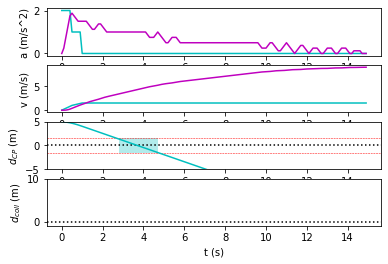

In [2]:
NAMES = ('P', 'V')
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

Baseline kinematics, base model - here changes are to be expected and indeed occur. The agents no longer pass each other with minimal margins. So in that sense it works as expected. 

Initial car distance 30 m:


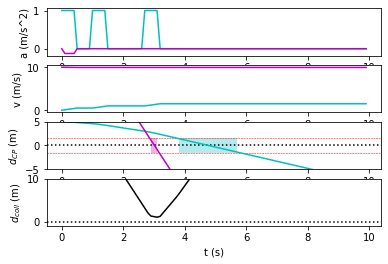

Initial car distance 40 m:


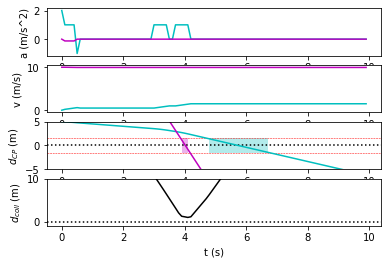

Initial car distance 50 m:


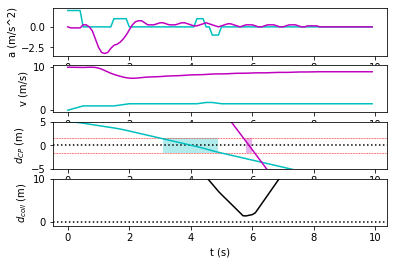

In [3]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), plot_beh_probs = False, 
                            plot_beh_activs = False, plot_beh_accs = False,
                            plot_looming = False, ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = SCSimulation(
                CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs,
                              looming = plot_looming)

run_baseline_kinematics()

### Simplified Keio-like scenario - here the safety margins do make the crossing more human-like

In this scenario, where the pedestrian starts at the curb, we do get the pedestrian starting a bit before the car comes to a stop, 0.3 s earlier than the model without safety margins. I have previously not been able to achieve this kind of early start for this scenario (compare for example the 2021-08-27 diary notes). In the earlier deterministic fits (see notes 2021-10-06b) there was a 0.1 s difference compared to the base model for some of the model variants, but never more. So this is positive.


*** Safety margins: 0
	oBEo = False


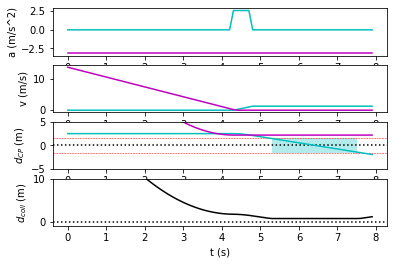

Agent P entered conflict area at t = 5.30 s
Agent V did not enter the conflict area.
	oBEo = True


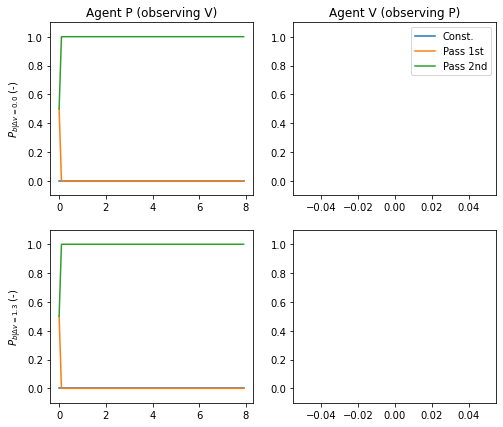

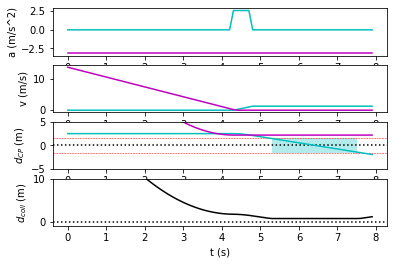

Agent P entered conflict area at t = 5.30 s
Agent V did not enter the conflict area.

*** Safety margins: 0.5
	oBEo = False


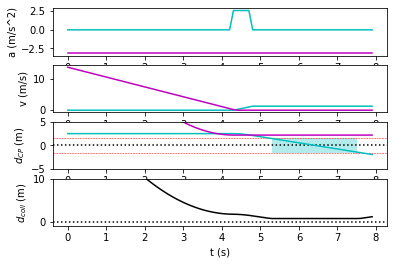

Agent P entered conflict area at t = 5.30 s
Agent V did not enter the conflict area.
	oBEo = True


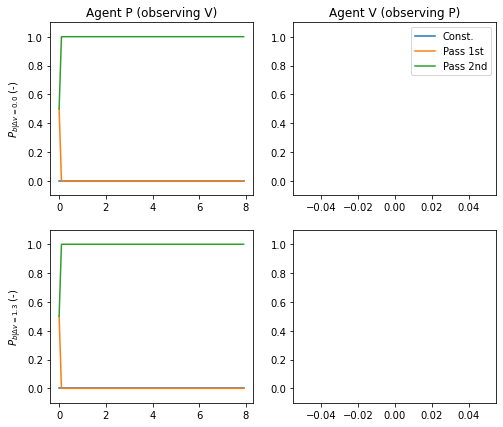

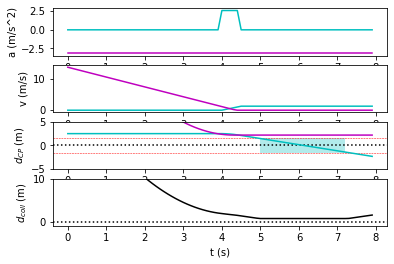

Agent P entered conflict area at t = 5.00 s
Agent V did not enter the conflict area.


In [9]:
import math

def run_keio_scenario(time_step = 0.1, T_P = 0.5, sigma_O = 0.01, 
                      T_s = 0, D_s = 0,
                      oVAa = False, oBEo = False, 
                      plot_beh_probs = False, 
                      ped_snapshot_times = None):
    INITIAL_POSITIONS = np.array([[0,-2.5], [13.9*2.29, 0]])
    GOALS = np.array([[0, 5], [-50, 0]])
    SPEEDS = np.array((0, 13.9))
    stop_dist = INITIAL_POSITIONS[1][0] - sc_scenario.SHARED_PARAMS.d_C
    CONST_ACCS = (None, -SPEEDS[1] ** 2 / (2 * stop_dist))
    
    # set parameters and optional assumptions
    AFF_VAL_FCN = True
    (params, params_k) = get_default_params(oVA = AFF_VAL_FCN)
    params.ctrl_deltas = np.array([0, 1.3]) # only a single move-forward action
    params.T_P = T_P
    params.T_s = T_s
    params.D_s = D_s
    params.T_O = math.inf
    params.sigma_O = sigma_O
    optional_assumptions = get_assumptions_dict(default_value = False, oVA = AFF_VAL_FCN,
                                               oVAa = oVAa, oBEo = oBEo)  

    # run simulation
    SNAPSHOT_TIMES = (ped_snapshot_times, None)
    sc_simulation = SCSimulation(
            CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
            end_time = 8, optional_assumptions = optional_assumptions,
            const_accs = CONST_ACCS, agent_names = NAMES,
            params = params, snapshot_times = SNAPSHOT_TIMES, time_step=time_step)
    sc_simulation.run()

    # plot and give some results feedback
    sc_simulation.do_plots(kinem_states=True, beh_probs=plot_beh_probs)
    for agent in sc_simulation.agents:
        ca_entered = np.nonzero(np.linalg.norm(agent.trajectory.pos, axis=0)
                                <= sc_scenario.SHARED_PARAMS.d_C)[0]
        if len(ca_entered) == 0:
            print('Agent %s did not enter the conflict area.' % agent.name)
        else:
            print('Agent %s entered conflict area at t = %.2f s' 
                  % (agent.name, sc_simulation.time_stamps[ca_entered[0]]))


for safety_margins in (0, 0.5):
    print(f'\n*** Safety margins: {safety_margins}')
    for oBEo in (False, True):
        print(f'\toBEo = {oBEo}')
        run_keio_scenario(oBEo=oBEo, plot_beh_probs=oBEo, T_s=safety_margins, D_s=safety_margins)

## Deterministic fits

However, below we see that in the actual deterministic fits, there is no longer any anticipation at all, not even by the previously observed 0.1 s.

In [10]:
%run ../SCPaper/do_2_analyse_deterministic_fits

['C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEo.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEooBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEooBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVA.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAa.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEo.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEooBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEooBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_o

Looking closer at one simulation of `ActPedPrioEncounter` with `oBEo`, we can see that we still have a problem with it looking "too scary" to start crossing before the vehicle has come to a complete stop. Part of the reason this happens now, it seems, is because with the increased safety margins the pedestrian stops and waits quite far from the curb, so crossing in front of the car requires very large accelerations until very late in the yielding process.

One particular thing I am noticing is that the value of "achieving the access" is higher in the bottom middle panel (1.8), where the pedestrian remains still and anticipates 6.1 s of 0.1 m/s^2 acceleration, compared to the panel to the right of it (1.5), where the the pedestrian has started walking a little and anticipates 4.8 s of 0.1 m/s^2 deceleration. I think this is to some extent due to the simplification of doing time discounting with respect to the start of each time period in the anticipated future, so the duration of that time period has an effect only on the discounting of the following time period, i.e., the 6.1 s vs 4.8 s doesn't play into the values of 1.8 and 1.5 here.

{'T_delta': 15, 'T_Of': 0.5, 'sigma_O': 0.02}


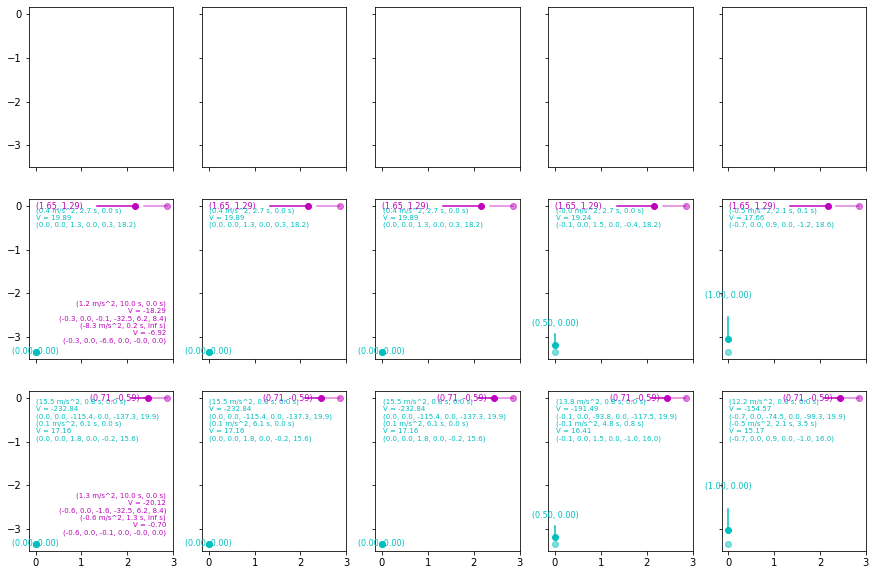

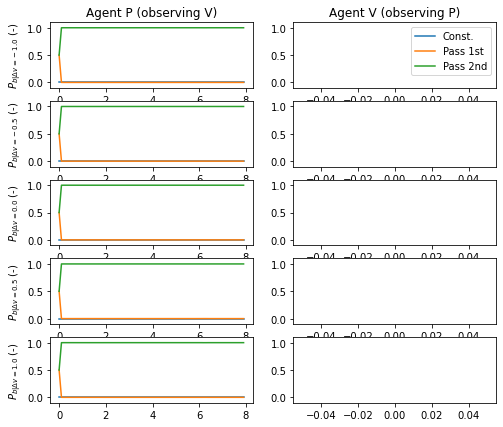

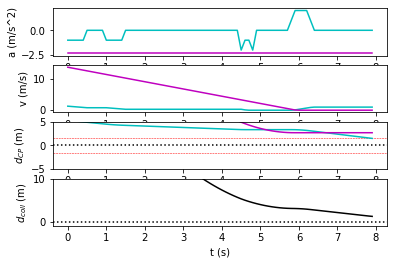

In [14]:
fit = det_fits['oVAoBEo']
free_params = (15, 0.5, 0.02)
print(fit.get_params_dict(free_params))
fit.set_params(free_params)
sim = fit.simulate_scenario(sc_fitting.DET1S_SCENARIOS['ActPedPrioEncounter'], snapshots=((5.5,), None))
sim.do_plots(kinem_states=True, beh_probs=True)

## Conclusions

Introducing the safety margins seems to be a sensible thing to do, and it might help with the probabilistic fits to our VR datasets, but it didn't solve the problem with the `ActPedPrioEncounter` scenario for the deterministic fits - if anything rather the opposite.

Some ideas for what to try next:
* How much is the behaviour we see above created by the coarse-grained time step and action repertoire of the agents? Would a finer-grain approach there for example cause the pedestrian to stop closer to the curb?
* Is it time to try the "looming over the entire prediction horizon" approach mentioned in the 2021-10-13 notes?